# Grid Cells

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from skimage.draw import line_aa
from scipy.stats import multivariate_normal
from tqdm import tqdm


device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [2]:
def get_grid_cell(period, res=400):
    angle = np.random.uniform(0, 2 * np.pi / 3)
    radius = np.ceil(res * 0.9).astype(int) # Should be radius > resolution / sqrt(2)
    
    lines = lines_at_60(angle, period, radius)
    lines = [zeros_with_line(*line_aa(*l), shape=[2 * radius + 1] * 2) for l in lines]
    
    image = np.sum(lines, axis=0) > 1
    image = clean_image(image)
    image = convolve(image, get_gaussian_kernel(int(np.ceil(1.5 * period))))
    
    phase_range = (radius - res // 2) // 2
    phase = np.random.randint(-phase_range, phase_range + 1, 2)
    image = crop_and_add_phase(image, res, phase)
    
    return image / image.max()

def lines_at_60(angle, period, radius):
    lines, l = list(), 0
    while l < radius:
        shift = np.arcsin(l / radius)
        x1, y1 = coords_on_circle(angle + shift, radius=radius)
        x2, y2 = coords_on_circle(angle + np.pi - shift, radius=radius)
        lines.append((x1 + radius, y1 + radius, x2 + radius, y2 + radius))
        if l > 0:
            x1, y1 = coords_on_circle(angle - shift, radius=radius)
            x2, y2 = coords_on_circle(angle + np.pi + shift, radius=radius)
            lines.append((x1 + radius, y1 + radius, x2 + radius, y2 + radius))
            x1, y1 = coords_on_circle(angle + np.pi / 3 + shift, radius=radius)
            x2, y2 = coords_on_circle(angle + np.pi / 3 + np.pi - shift, radius=radius)
            lines.append((x1 + radius, y1 + radius, x2 + radius, y2 + radius))
        x1, y1 = coords_on_circle(angle + np.pi / 3 - shift, radius=radius)
        x2, y2 = coords_on_circle(angle + np.pi / 3 + np.pi + shift, radius=radius)
        lines.append((x1 + radius, y1 + radius, x2 + radius, y2 + radius))
        l += period
    return lines

def coords_on_circle(angle, radius=1):
    lin = radius * np.e**(1j * angle)
    y, x = np.ceil([lin.real, lin.imag]).astype(int)
    return x, y

def zeros_with_line(rr, cc, val=1, shape=None):
    if shape is None:
        shape = (rr.max() + 1, cc.max() + 1)
    z = np.zeros(shape)
    z[rr, cc] = val
    return z

# Remove duplicated intersection points.
# Bad intersections can be of the following forms:
# [[1, 0],  |  [[0, 1],  \  [[1, 1]]  |  [[1],
#  [0, 1]]  \   [1, 0]]  |            \   [1]]
def clean_image(image):
    image[np.where(image[:, :-1] & image[:, 1:])] = False
    image[np.where(image[:-1] & image[1:])] = False
    image[np.where(image[1:, 1:] & image[:-1, :-1])] = False
    rr, cc = np.where(image[1:, :-1] & image[:-1, 1:])
    image[rr + 1, cc] = False
    return image

def convolve(image, kernel):
    shape = np.asarray(kernel.shape) // 2 + image.shape
    image = np.fft.rfft2(image, shape) * np.fft.rfft2(kernel, shape)
    image = np.fft.irfft2(image)
    return np.where(np.isclose(image, 0, atol=1e-4), 0, image)[kernel.shape[0] // 2:, kernel.shape[1] // 2:]
    
def get_gaussian_kernel(res, lower=-5, upper=5):
    x, y = np.linspace(lower, upper, res), np.linspace(lower, upper, res)
    xx, yy = np.meshgrid(x, y)
    coords = np.concatenate([xx[:,:,np.newaxis], yy[:,:,np.newaxis]], axis=-1)
    return grid(coords, [multivariate_normal([0, 0], cov=np.eye(2))])

def grid(coords, distributions):
    shape = coords.shape[:2]
    return np.asarray([dist.pdf(coords.reshape(-1, 2)).reshape(*shape)
                       for dist in distributions]).sum(axis=0) / len(distributions)

def crop_and_add_phase(image, res, phase):
    x, y = image.shape
    x, y = (x - res) // 2 + phase[0], (y - res) // 2 + phase[1]
    return image[x:x + res, y:y + res]

def dist(w, probs, place):
    return np.sum((probs.T @ w - place)**2 * (place + 0.1))

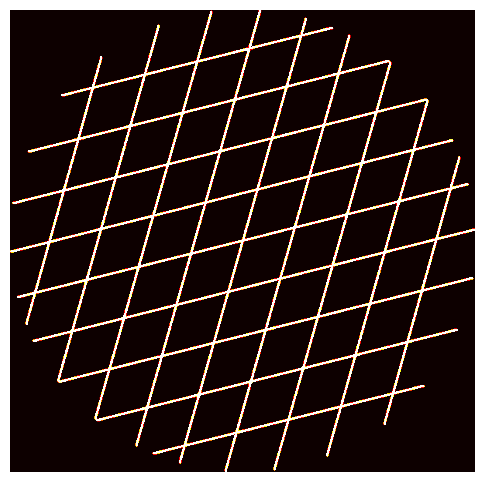

In [3]:
angle = np.random.uniform(0, 2 * np.pi / 3)
period = 60
radius = 300

z = np.any([zeros_with_line(*line_aa(*l), shape=[2 * radius + 1] * 2)
            for l in lines_at_60(angle, period, radius)], axis=0)

plt.figure(figsize=(6, 6))
plt.contourf(z, levels=100, cmap='hot')
plt.axis('off')
plt.show()

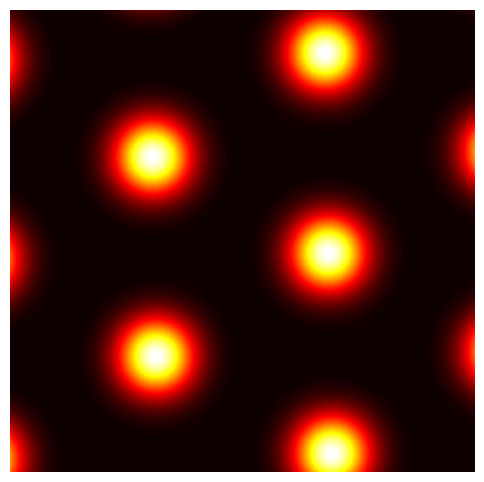

In [4]:
plt.figure(figsize=(6, 6))
plt.contourf(get_grid_cell(150), levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [5]:
resolution = 400
MIN, MAX = -1, 1

x, y = np.linspace(MIN, MAX, resolution), np.linspace(MIN, MAX, resolution)
xx, yy = np.meshgrid(x, y)
coords = np.concatenate([xx[:,:,np.newaxis], yy[:,:,np.newaxis]], axis=-1)

In [6]:
coord = [0, 0]
mvn = multivariate_normal(mean=coord, cov=np.eye(2) * 0.001)
place = grid(coords, [mvn])
place /= place.max()

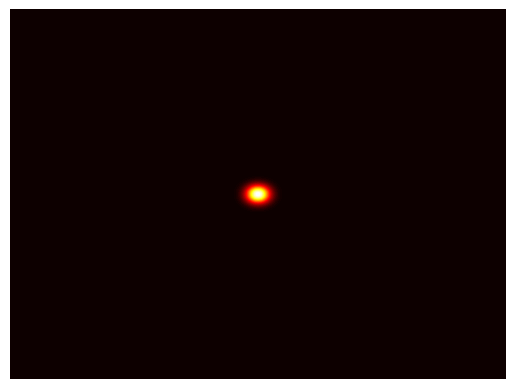

In [7]:
plt.contourf(place, levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [12]:
coords.max()

1.0

In [8]:
N = 10
grid_cells = np.asarray([get_grid_cell(period, res=resolution)
                         for period in np.linspace(40, 150, 11)
                         for _ in range(N)])

# Purge delinquent cells
means = grid_cells.mean(axis=(1, 2))
grid_cells = grid_cells[~(means < means.mean() - means.std() * 4)]

In [9]:
p = torch.tensor(grid_cells, dtype=torch.float32, device=device).permute((1, 2, 0))
w = torch.randn(len(grid_cells), requires_grad=True, device=device)
pl = torch.tensor(place, dtype=torch.float32, device=device)
lr = 1e-5

for _ in tqdm(range(10000)):
    loss = torch.sum((p @ w - pl)**2 * (pl + 0.1))
    loss.backward(inputs=[w])
    w = w - lr * w.grad

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 857.49it/s]


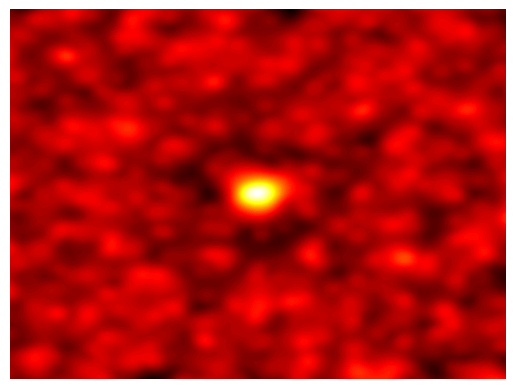

In [10]:
plt.contourf((p @ w).detach().cpu(), levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [11]:
coord = [-.5, -.5]
mvn = multivariate_normal(mean=coord, cov=np.eye(2) * 0.01)
place = grid(coords, [mvn])
place /= place.max()

In [12]:
p = torch.tensor(grid_cells, dtype=torch.float32, device=device).permute((1, 2, 0))
w = torch.randn(len(grid_cells), requires_grad=True, device=device)
pl = torch.tensor(place, dtype=torch.float32, device=device)
lr = 1e-5

for _ in tqdm(range(10000)):
    loss = torch.sum((p @ w - pl)**2 * (pl + 0.1))
    loss.backward(inputs=[w])
    w = w - lr * w.grad

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 857.14it/s]


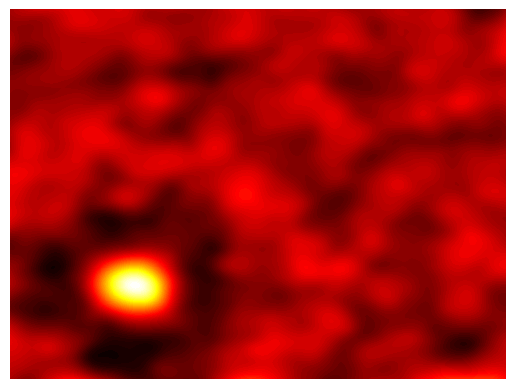

In [13]:
plt.contourf((p @ w).detach().cpu(), levels=100, cmap='hot')
plt.axis('off')
plt.show()